### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample
from tqdm import tqdm

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-06 12:00:32--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.003s  

2024-11-06 12:00:32 (75.5 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [4]:
len(text)

141888

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [5]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [7]:
chunk = next(generate_chunk())
chunk

array([[83, 71, 50, ..., 50, 52, 49],
       [83, 50,  1, ..., 45, 58, 76],
       [83, 63,  1, ..., 45, 61, 63],
       ...,
       [83, 45, 58, ..., 61, 59, 47],
       [83, 73, 75, ..., 53, 54,  5],
       [83,  0, 53, ...,  5,  1, 55]])

In [8]:
chunk.shape

(256, 101)

Далее вам предстоит написать код для обучения модели и генерации текста.

In [107]:
def train_model(model, optimizer, criterion, batch_size=256, num_epoch=5):
    torch.cuda.empty_cache()
    model.train()
    losses = []
    best_loss = float('inf')
    best_model = None

    for epoch in tqdm(range(num_epoch)):
        hidden = model.init_hidden(batch_size)
        epoch_losses = []
        batch = next(generate_chunk())

        inputs = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
        targets = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)

        optimizer.zero_grad()

        #logits = model(inputs).flatten(start_dim=0, end_dim=1)
        #loss = criterion(logits, batch['target_ids'].flatten())
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.view(-1, num_tokens), targets.view(-1))


        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
      #  print(f'Epoch {epoch+1}; Loss: {loss.item():.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    model.load_state_dict(best_model)
    print('Best Loss:', best_loss)
    return model

100%|██████████| 5000/5000 [03:23<00:00, 24.54it/s]


Best Loss: tensor(0.2821, device='cuda:0', grad_fn=<NllLossBackward0>)


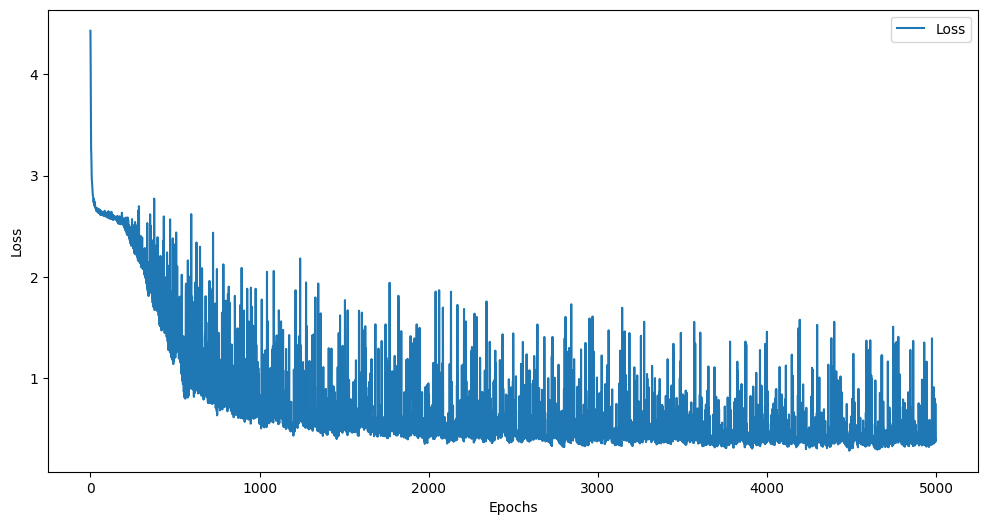

In [108]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.35)

    def forward(self, x, hidden) -> torch.Tensor:
        embeddings = self.embedding(x)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(output)  # [batch_size, seq_len, vocab_size]

        return projection, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim)

# LSTM 1 LAYER
model = CharLM(hidden_dim=256, vocab_size=num_tokens).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
model = train_model(model, optimizer, criterion, batch_size=256, num_epoch=5000)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

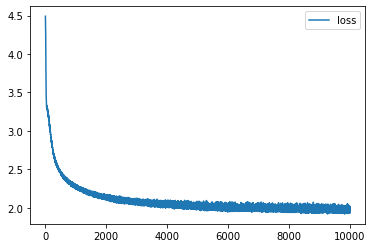

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [109]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    # your code here

    hidden = char_rnn.init_hidden(1).to(device)
    # Прогоняем начальную последовательность через сеть
    for i in range(len(x_sequence[0]) - 1):
        _, hidden = char_rnn(x_sequence[:, i].unsqueeze(1), hidden)

    # Генерация символов
    for i in range(max_length - len(x_sequence[0]) + 1):
        output, hidden = char_rnn(x_sequence[:, -1].unsqueeze(1), hidden)

        # Применяем температуру
        output = output / temperature
        probabilities = torch.softmax(output[0, -1], dim=0).detach().cpu().numpy()

        # Выбираем следующий символ
        next_idx = np.random.choice(range(num_tokens), p=probabilities)
       # next_char = idx_to_token[next_idx]

        # Добавляем выбранный символ к результату и обновляем вход
        #generated_text += next_char
        x_sequence = torch.cat((x_sequence, torch.tensor([[next_idx]], dtype=torch.int64).to(device)), dim=1)


    return  ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [110]:
sample = generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.49)
print(len(sample))
print(sample)

505
<sos> мой дядя самых честных правила сть,
и в ди де содо,
огдре ди о всте вза при в де ста бымев ми же,
ихой,
все пода в пи ой ме дрет ди медь ди поколоност нот ост сто,
онат де пой гдоди подет встодла, в ской
xxxxxxxxxxxxxxxxxxxxxi

в се демедоль т одре пой пол пи конона,
имевской в ой ко пойкадий,
всодонь,

в на,
их пола вской,
и поко поновсодов деладелат пой пойкой ой,
чедемой, вски в пре ой пида,

ластв ни в коче,


т по кой поль, пой ди м на одим сь,
и в за стья, вза пи кой нь, пей,
ой сть,
ой,



In [120]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.25))

<sos> мой дядя самых честных правила сой мель, ди пой,
вся, м, ся сой м сь коне ска поной посой, пой пой, ной,
в пи пот пи поныкоди в сть, по пой поне в вей подре медеми м в пой пост пой нья по ся, поне оде в пой пой дель, взе ся.
ой мет нододи стья,
в поный пода пола ноне ми поль, пой в пой,

ой пой сой,

ой, сть,
вой кой подой понь,
и пой, вета ой м,
в м поноть, ков дела ст ской кой м пой ме пой ме пой сядела мев ска ме пой сть,

вст поной пи ме мой пой подела стей пи мела соной,
и дим пов пой ве д


In [113]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.17))

<sos> мой дядя самых честных правила ст поной,



в м в сть,

вей на ской по пой, мой,
ола ст м пола поди сой в дей м дрой пой м сте пи поль,
от пой поде пой в пой пой по м пой пой пой м,
пой,
ой пой,
в м всь,
ола пола оной м м м в м ме пой пой, пой ст пой в в поди поди пой
в пой пот ме ве мой скоди ме в поде онодей, ме поде кой в подой

в пола ой пододи подела в пой ст ста,
пой ми кой,
в м м ста дей в ме по меди пой,
ой ми пой от пой соте в пой ме всконой доди пола подой,
ола пой м в ст ла в сть,
в 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [121]:
seed_phrase = ' мой дядя самых честных правил'

In [122]:
#generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=0.49
    ).replace('<sos>', '')
    for _ in range(10)
]
for phrase in generated_phrases:
  print(len(phrase))

500
500
500
500
500
500
500
500
500
500


In [123]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!